## Latent Space Models

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import networkx as nx

from edward.models import Normal, Poisson, InverseGamma
#from observations import celegans

In [5]:
X = pd.read_csv("/Users/oliver/Downloads/network_subset.csv") # 2.14 GB
X.columns = ['id', 'dst_id',"src_id"]

In [6]:
X.iloc[:10000, 1:3].to_csv("Data/network_subset.edgelist",sep = " " ,index = False)

In [7]:
G = nx.read_edgelist("Data/network_subset.edgelist") # read and parse edgelist to (networkx) graph
A = nx.adjacency_matrix(G) # make Adjacency matrix
x_train = np.asarray(A.todense()) # convert Adjacency matrix to numpy array

## Visualization of network data (subset)

In [ ]:
nx.draw(G, node_size = 5)  # networkx draw()
plt.draw()
plt.show()

/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()


## Latent Space Models

In [5]:
from edward.models import Normal, Poisson

N = x_train.shape[0]  # number of data points
K = 50  # latent dimensionality

z = Normal(loc=tf.zeros([N, K]), scale=tf.ones([N, K]))

# Calculate N x N distance matrix.
# 1. Create a vector, [||z_1||^2, ||z_2||^2, ..., ||z_N||^2], and tile
# it to create N identical rows.
xp = tf.tile(tf.reduce_sum(tf.pow(z, 2), 1, keepdims=True), [1, N])
# 2. Create a N x N matrix where entry (i, j) is ||z_i||^2 + ||z_j||^2
# - 2 z_i^T z_j.
xp = xp + tf.transpose(xp) - 2 * tf.matmul(z, z, transpose_b=True)
# 3. Invert the pairwise distances and make rate along diagonals to
# be close to zero.
xp = 1.0 / tf.sqrt(xp + tf.diag(tf.zeros(N) + 1e3))

x = Poisson(rate=xp)

## Latent Space modified

In [ ]:
#from edward.models import Bernoulli, Beta

#theta = Beta(1.0, 1.0)
#x = Bernoulli(probs=tf.ones(50) * theta)

In [23]:
from edward.models import Normal, Bernoulli, InverseGamma

N = x_train.shape[0]  # number of data points
K = 3  # latent dimensionality

scale_z = InverseGamma(tf.ones(1,K),(1,K))

#scale_z = InverseGamma(10**(-3),10**(-3)) Denne skal måske bruges.

scale_b = InverseGamma(10e-2,10e-3) #Gelman 2006

z2 = Normal(loc=tf.zeros([N, K]), scale = (tf.sqrt(scale_z)*tf.ones([N, K])))

z1 = Normal(loc=tf.zeros([N, K]), scale = (tf.sqrt(scale_z)*tf.ones([N, K])))
            
b = Normal(loc=tf.zeros(1), scale = (tf.sqrt(scale_b)*tf.ones(1)))


# Calculate N x N distance matrix.
# 1. Create a vector, [||z_1||^2, ||z_2||^2, ..., ||z_N||^2], and tile
# it to create N identical rows.
pi1 = tf.tile(tf.reduce_sum(tf.pow(z1, 2), 1, keepdims=True), [1, N])
pi2 = tf.tile(tf.reduce_sum(tf.pow(z2, 2), 1, keepdims=True), [1, N])
           
           
# 2. Create a N x N matrix where entry (i, j) is ||z_i||^2 + ||z_j||^2
# - 2 z_i^T z_j.
pi = pi1 + tf.transpose(pi2) - 2 * tf.matmul(z1, z2, transpose_b=True)
# 3. minus pairwise distances and make rate along diagonals to
# be close to zero.
pi = -tf.sqrt(pi + tf.diag(tf.zeros(N) + 1e3))

pi = tf.sigmoid(pi + b) #med bias (mange eller få links)

x = Bernoulli(pi)

ValueError: Expected floating point type, got <dtype: 'int32'>.

In [7]:
1e-3

0.001

In [3]:
10**(-3)

0.001

In [13]:
a = tf.pow(10, -3)

In [20]:
10**(-3)

0.001

In [9]:
scale_z = InverseGamma(10^(-3),10^(-3))

ValueError: Expected floating point type, got <dtype: 'int32'>.

In [6]:
inference = ed.MAP([z1,z2,b], data={x: x_train})

/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


In [18]:
z.eval()

array([[-1.1297144 , -1.974744  , -0.1672822 , ...,  0.0331337 ,
        -1.3160638 ,  0.2037237 ],
       [ 1.7305766 ,  0.52205867,  0.49213013, ..., -0.96997064,
        -0.3929947 , -1.6222007 ],
       [ 0.76104224,  0.01201328,  0.07099432, ..., -1.1320577 ,
        -2.0946603 , -0.31216198],
       ...,
       [ 0.07497098,  1.0896178 ,  0.57064676, ..., -1.1355695 ,
         0.6341806 , -1.7363889 ],
       [-0.6167602 , -0.2931429 , -0.3887113 , ..., -1.2434862 ,
        -0.9412726 , -0.6463135 ],
       [-2.7146416 , -1.1716983 ,  0.3224456 , ..., -0.8835547 ,
        -0.11351845, -1.0442084 ]], dtype=float32)

For MAP to optimize over latent variables with constrained continuous support, the point mass must be constrained to have the same support while its free parameters are unconstrained, set [ ]

In [59]:
#inference.run(n_iter=2500, logdir = "log")

250/250 [100%] ██████████████████████████████ Elapsed: 139s | Loss: 2396402.250

In [7]:
inference.initialize(n_iter=200,logdir='log')

tf.global_variables_initializer().run()

info_loss = np.zeros(200)


for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  info_loss[_] = info_dict['loss']


inference.finalize()

200/200 [100%] ██████████████████████████████ Elapsed: 2615s | Loss: 47761368.000

Latent dim: 10    | Elapsed: 520s | Loss: 13005462

Latent dim: 50    | Elapsed: 537s | Loss: 13163543

Latent dim: 100    | Elapsed: 585s | Loss: 13362563

Latent dim: 1000 | Elapsed: 1021s | Loss: 16953428

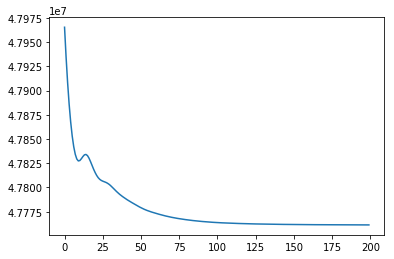

In [8]:
plt.plot(info_loss[:200])
plt.show()

In [142]:
#Z_pred = x.mean().eval().argmax(axis=1)
#print("Result (label flip can happen):")
#print("Predicted")
#print(Z_pred)

In [53]:
x

<ed.RandomVariable 'Bernoulli_4/' shape=(4336, 4336) dtype=int32>

In [19]:
x_train

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## Visualization of Latent Space Model result

In [30]:
G=nx.from_numpy_matrix(x.eval())

/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:137: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


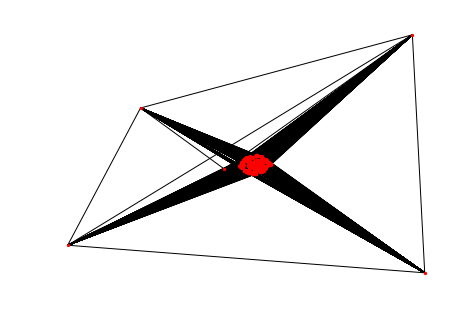

In [31]:
nx.draw(G, node_size = 5)  # networkx draw()
plt.draw()
plt.show()

/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:137: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


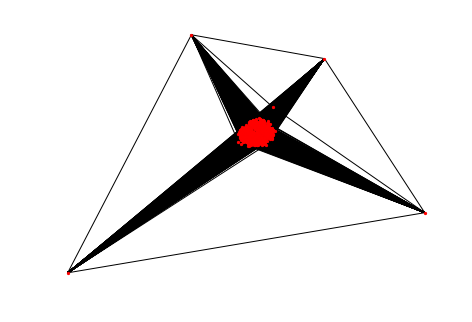

In [123]:
G=nx.from_numpy_matrix(x.eval())
nx.draw(G, node_size = 5)  # networkx draw()
plt.draw()
plt.show()